# AS - TME6
2018-2019

Binome : Stieban Fernandez, Juliette Ortholand

---

Préparation des données

In [1]:
import sys
sys.path.insert(0, "/users/Enseignants/baskiotis/.local/lib/python3.5/site-packages")

In [2]:
import logging
import torchtext
import torchtext.datasets as datasets
import torchtext.data as data
import torch.nn as nn
import torch

import tensorboard
import tensorboardX
import tensorflow
import spacy
import nltk

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
DATA_DIR="C:\\Users\\Juliette\\Documents\\data_as"

DATASET_DIR="%s/datasets" % DATA_DIR
VECTORS_DIR="%s/vectors" % DATA_DIR

# text
TEXT=data.Field(lower=True,include_lengths=False,batch_first=True)
LABEL = data.Field(sequential=False, is_target=True)

# make splits for data
train, val, test = datasets.sst.SST.splits(TEXT, LABEL,root=DATASET_DIR)

# Use the vocabulary
wordemb = torchtext.vocab.GloVe("6B", dim=100, cache=VECTORS_DIR)
# Build the vocabularies
# for labels, we use special_first to False so <unk> is last
# (to discard it)
TEXT.build_vocab(train, vectors=wordemb)
LABEL.build_vocab(train, specials_first=False)
train_iter, val_iter, test_iter = data.BucketIterator.splits(
(train, val, test), batch_size=1000, device=0)

nn_embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [4]:
TEXT.vocab.vectors.shape

torch.Size([16583, 100])

In [5]:
nn_embeddings

Embedding(16583, 100)

Test

In [46]:
class ConvNet1(nn.Module):
    
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(100, 300, kernel_size=3, stride=1),
        )
        self.tret = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3)
        )
        self.clas = nn.Sequential(
            nn.Linear(300, 3),
            #nn.ReLU(),
            #nn.Linear(100, 3)
        )
    
    def forward(self, X):
        out = self.conv1(X)
        out = self.tret(out)
        out = out.mean(dim=len(out.shape)-1)
        out = out.view(X.shape[0], -1)
        out = self.clas(out)
        return out
    
    def score(self,ypred,y):
        score = 0
        if len(y) != len(ypred):
            print('ERREUR')
        for i in range(0,len(y)):
            if y[i] == ypred[i].argmax():
                score += 1
        return(score/len(y))

In [53]:
model = ConvNet1()
loss = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

train_loss = []
val_loss = []

train_score = []
val_score = []


### Train
#--------------------------------------------------------
for i in range(10):
    print(i)
    ####### TRAIN #######
    costs_train = []
    scores_train = []
    for batch in train_iter:
        t = batch.text # batch_size phrases de max nb mots (taille variable), reste du vecteur complété par 1
        l = batch.label # vecteur de 10 
        x = nn_embeddings(t).transpose(1,2) # shape : (batch_size, input_channels, nb_mots_max)

        out = model(x)
        cost = loss(out, l)
        optim.zero_grad()
        cost.backward()
        optim.step()
        costs_train.append(cost)
        scores_train.append(model.score(out, l))
    train_loss.append(torch.tensor(costs_train).mean())
    train_score.append(torch.tensor(scores_train).mean())
    
    ####### VALID #######
    costs_val = []
    scores_val = []
    for k, batch_test in enumerate(test_iter):
        t_test = batch_test.text 
        l_test = batch_test.label 
        x_test = nn_embeddings(t_test).transpose(1,2)

        out_test = model(x_test)
        cost_test = loss(out_test, l_test)
        costs_val.append(cost_test)
        scores_val.append(model.score(out_test,l_test))
    val_score.append(torch.tensor(scores_val).mean())
    val_loss.append(torch.tensor(costs_val).mean())


0
1
2
3
4
5
6
7
8
9


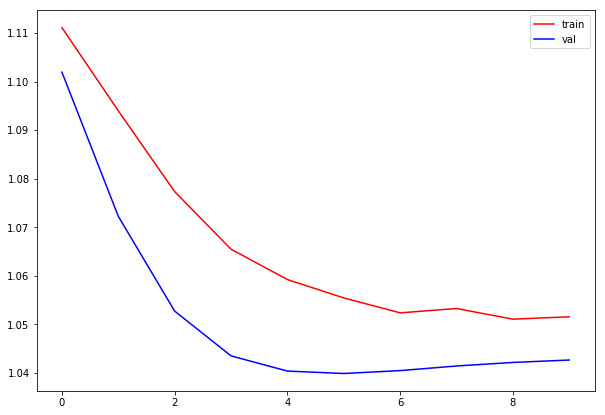

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(train_loss, c="red", label="train")
plt.plot(val_loss, c="b", label="val")
plt.legend(loc="best")
plt.show()

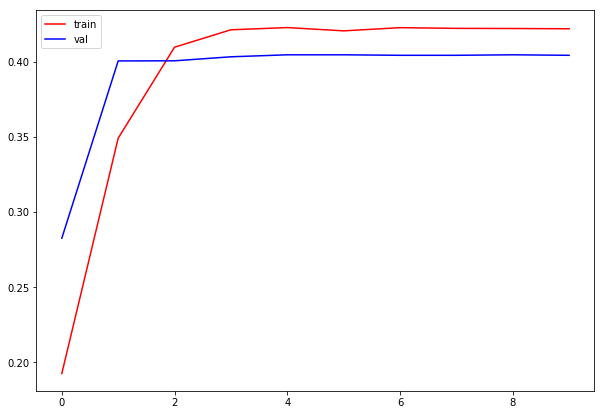

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(train_score, c="red", label="train")
plt.plot(val_score, c="b", label="val")
plt.legend(loc="best")
plt.show()

In [56]:
costs_val = []
scores_val = []
for i, batch in enumerate(val_iter):
    t = batch.text 
    l = batch.label 
    x = nn_embeddings(t).transpose(1,2)

    out = model(x)
    cost = loss(out, l)
    costs_val.append(cost)
    scores_val.append(model.score(out, l))
print(torch.tensor(scores_val).mean())
print(torch.tensor(costs_val).mean())

tensor(0.3689)
tensor(1.0972)


Que se passe-t-il dans un CNN?
- Etude des filtres

Travail en batch

Chaque vecteur correspond a un filtre

Remonter l'information de position, savoir a quelle portion de l'entrée le vecteur fait référence

- Pour chaque phrase, pour chaque composante : max 
- Quels sont les bouts de séquence qui activent le plus le filtre
- $(w_i, s_i) \rightarrow (w,s) \rightarrow (w_o, s_o)$ : voir le stride
- la $j_ième$ sortie correspond à ($j s_o$)... ($j s_o + w_o - 1$)

Qu'est ce qui explique ma classification ?

Quelles sont les parties de ma phrase qui définissent ce qui est positif, negatif, etc

Conv -> max pooling (1 vecteur en sortie) -> softmax

ex : Comment varie l'embedding par rapport à la sortie

- Gradient de la sortie correspondante dans le module linéaire au niveau de softmax le softmax par rapport à l'entrée x
- Si on s'apercçoit que les dérivées sont fortes --> importance

norme du gradient de X par rapport au $j_ième$ vecteur (ne pas oublier requires_grad=True)

Construction d'un réseau